# The Soundex Algorithm

The following is an FST implementation of the Soundex algorithm in __PyFoma__. Its purpose is to map phonetically similar names to the same letter+number sequence. See for example [The National Archives](https://www.archives.gov/research/census/soundex.html) for details.

Here's an alternative description of the algorithm in 4 steps (following Don Knuth in [TAOCP vol. 3, p. 394](https://www-cs-faculty.stanford.edu/~uno/taocp.html)):

 1. Retain the first letter of the name and drop all other occurrences of a, e, h, i, o, u, w, y.

 2. Replace consonants after the first letter with numbers, as follows:


```
    b, f, p, v => 1
    c, g, j, k, q, s, x, z => 2
    d, t => 3
    l => 4
    m, n => 5
    r => 6
```

 3. If two or more letters with the same number were adjacent in the original name (before step 1), or adjacent except for intervening h's and w's, omit all but the first.
 
 4. Convert to the form “letter, digit, digit, digit” by adding trailing zeros (if there are less than three digits), or by dropping rightmost digits (if there are more than three).
 
 Notice that Knuth's description really is such that step 3 is __applied first__, then step 1, step 2, and step 4. This is because step 3 references something existing "before step 1", i.e. information which applying step 1 first would destroy.
 
      
## Examples

```
w a s h i n g t o n
w   2     5 2 3   5
```

This becomes `w252`, i.e. we only save the first three numbers (because of step 4). A bit more challenging is

```
p f i s t e r
p 1   2 3   6
```

Here, step 3 applies: `f` is in the same group as `p`, so we skip it, with the result `p236`.

In the example

```
a s h c r a f t
a 2   2 6   1 3
```

we don't count the `c` since the `s` and the `c` are separated by an `h` and step 3 applies ("except for intervening h's and w's..."). The result is `a261`.


In the final definition where we compose together the FSTs representing each step, we also add an additional feature where non-ASCII characters are deleted as the very first step. This is to ensure that names with letters outside `[a-z]` also get some representation.

# The code

In [1]:
from pyfoma import FST
defs = {}                          # Empty dictionary so store intermediate definitions
defs['s1'] = FST.re("[bfpv]")      # Group definitions...
defs['s2'] = FST.re("[cgjkqsxz]")
defs['s3'] = FST.re("[dt]")
defs['s4'] = FST.re("l")
defs['s5'] = FST.re("[mn]")
defs['s6'] = FST.re("r")

defs['step3'] = FST.re("$^rewrite($s1 ([hw]* $s1:'')* |" # Longest-leftmost rewrite rule
                                 "$s2 ([hw]* $s2:'')* |" # to remove adjacent letters in 
                                 "$s3 ([hw]* $s3:'')* |" # the same group, except the first.
                                 "$s4 ([hw]* $s4:'')* |"
                                 "$s5 ([hw]* $s5:'')* |"
                                 "$s6 ([hw]* $s6:'')*, longest = True, leftmost = True)", defs)

defs['step1'] = FST.re(". ([aehiouwy]:'' | [^aehiouwy])*")   # remove all [aehiouwy]
defs['step2'] = FST.re(". ($s1:1|$s2:2|$s3:3|$s4:4|$s5:5|$s6:6)*", defs) # map letters to group number
defs['step4'] = FST.re(".* ((.:'')* | ('':0)*) @ .[0-9]{3}") # arbitrarily insert 0s or delete [0-9]s, then
                                                               # compose with filter, forcing .[0-9]{3} output
defs['soundex'] = FST.re("([a-z]|[^a-z]:'')* @ $step3 @ $step1 @ $step2 @ $step4", defs)

# Testing

We can now test the transducer in many ways. One is to call the `FST` method `generate`, which will pass words through the FST and return all outputs. It returns a generator (not a list), so we need to convert the possible outputs to a list to print them.

In [2]:
names = ["washington", "pfister", "ashcraft", "knuth", "gauss", "lebowski"]
for name in names:
    print(list(defs['soundex'].generate(name)))

['w252']
['p236']
['a261']
['k530']
['g200']
['l120']


The repetitive section in the code where step 3 is defined could of course be constructed by building the lomg union regex with Python using `join` and a comprehension. So, the line

```python
defs['step3'] = FST.re("$^rewrite($s1 ([hw]* $s1:'')* |"
                                 "$s2 ([hw]* $s2:'')* |"
                                 "$s3 ([hw]* $s3:'')* |"
                                 "$s4 ([hw]* $s4:'')* |"
                                 "$s5 ([hw]* $s5:'')* |"
                                 "$s6 ([hw]* $s6:'')*, longest = True, leftmost = True)", defs)
```
                                 
could be built by

```python
defs['step3'] = FST.re("$^rewrite(" + \
                     '|'.join("$s{} ([hw]* $s{}:'')*".format(s,s) for s in range(1,7)) + \
                       ", longest = True, leftmost = True)", defs)
```

suffering a little in terms of readability, however.

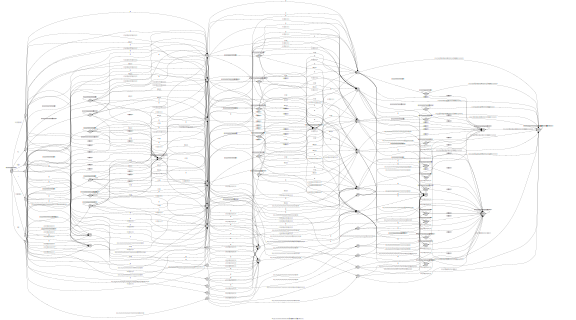

In [3]:
# The transducer in its full glory
defs['soundex'].view()